In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib as np
from IPython.display import display, HTML
import xlwt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import rcParams
rcParams['figure.figsize']=10,6
rcParams['lines.linewidth'] = 2
sns.set_style('whitegrid')
rcParams['grid.linestyle']='dotted'
rcParams['legend.loc'] = 'best'


def read_files(path):
    worker_id_exclude = ['fabian', 'nexus5', 'chiefsci', 'a1w8fa5gsfy60c'] # Test users
    readThis = ['TP__facebook_log.csv', 'TP__admin.csv']
    parse_dates = ['fb_date']
    dtype = {'worker_id':'str','fb_date':'str', 'time_spent':'int', 'time_open':'int'}
    df1 = pd.read_csv(path + '/' + readThis[0], usecols = ['worker_id','fb_date','time_spent', 'time_open'], dtype=dtype,parse_dates=parse_dates )
    df2 = pd.read_csv(path + '/' + readThis[1],na_values = 'NaN', usecols = ['worker_id','admin_experiment_group'],dtype = {'worker_id':'str', 'admin_experiment_group':'category'})
    df2 = df2.dropna(axis=0, how='any')
    df = pd.merge(df1,df2, on='worker_id')
    df = df.drop(df[df.worker_id.isin(worker_id_exclude)].index)
   
    return df

data = read_files("/Users/yulia/Desktop/db-dump/8.10") # Location of the DB files


In [459]:
# Remove unrelated to the experiment days
data = data.reset_index()
data = data.drop(data.index[data.fb_date <= '2017-07-13'])

groups = data.admin_experiment_group.unique()
data = data.drop('index', axis=1)
display(data.head(), data.tail())

# Write to file
#w = pd.ExcelWriter('FB_Data.xls')
#data.to_excel(w,'Sheet1')
#w.save()

,worker_id,fb_date,time_spent,time_open,admin_experiment_group
0,au7a3qnjf3o00,2017-07-14,395,2,2
1,au7a3qnjf3o00,2017-07-15,1425,2,2
2,au7a3qnjf3o00,2017-07-16,1605,2,2
3,au7a3qnjf3o00,2017-07-17,1120,3,2
4,au7a3qnjf3o00,2017-07-18,460,5,2


,worker_id,fb_date,time_spent,time_open,admin_experiment_group
3137,a2gg7hio2oixur,2017-07-30,18135,37,2
3138,a2gg7hio2oixur,2017-07-31,10485,17,2
3139,a2gg7hio2oixur,2017-08-01,10115,36,2
3140,a2gg7hio2oixur,2017-08-02,10545,19,2
3141,a2gg7hio2oixur,2017-08-03,12455,35,2


In [457]:

## Data Cleanup - Remove duplicate rows and add day count  ==> DataFrame: new_df

new_df = pd.DataFrame()
ids = data.worker_id.drop_duplicates()

    ### Drop Duplicates and Combine Code Block ###
## ----------------------------------------------------------------------
for i in ids:    # add days count for every worker_id 
    df_ = data[data.worker_id==i]
    # If has duplicate dates entires for a user, remove duplicates 
    # and if time_spent is not the same, add the times to one day and update the row
    df_dup = df_[df_.duplicated('fb_date')] # table for duplicated rows in the original data
    dropped = df_.drop_duplicates('fb_date') # table for new tavle without the duplicated rows
    dates_dup = list(df_dup.fb_date) # list of duplicated dates to compare 
    for row in dropped.fb_date:
        if row in dates_dup:
            time_s_dup = int(df_dup.time_spent[df_dup.fb_date==row]) # time_spent in table of duplicated rows
            time_s_dropped = int(dropped.time_spent[dropped.fb_date==row]) # time_spent in new table without duplicates
            if time_s_dup!=time_s_dropped: # if times are different, add them. Else, ignore
                new_time_s = time_s_dup + time_s_dropped
                dropped.time_spent[dropped.fb_date==row] = new_time_s

    dropped.insert(2, 'day_count', range(1, len(dropped)+1))
    new_df = new_df.append(dropped, ignore_index=True)
## ----------------------------------------------------------------------
new_df = new_df[new_df.day_count <=26] # <==== Filter to up to 25 Days

groups = list(new_df.admin_experiment_group.unique())
groups.sort()
  

## Daily Av. Statistics per user per group

Group 0: 60
Group 1: 59
Group 2: 56


,worker_id,day_count,time_spent,time_open,admin_experiment_group,Total_time_S,worker_count,av_TS_perD
0,a3hneyfoijwph1,2,28.50,5,0,83810,59,23.68
1,a1fyfbifytmjs,2,4.58,6,0,83810,59,23.68
2,a340ugidgif4w6,2,19.33,1,0,83810,59,23.68
3,a2bn1cx0ptwbxw,2,84.75,19,0,83810,59,23.68
4,a1n16zu0fnqey6,2,46.50,7,0,83810,59,23.68


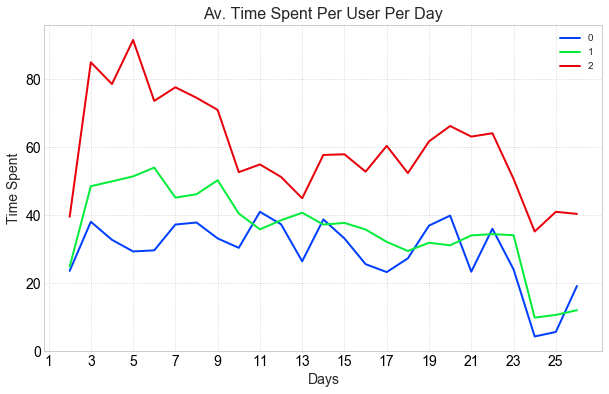

In [458]:
## Plot Av. Time Spent Per User Per Day ==> DataFrame: full_df

fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_title("Av. Time Spent Per User Per Day", fontsize=16)
ax1.tick_params(labelcolor='black',labelsize=14)
ax1.set_xlabel('Days', fontsize = 14)
ax1.set_ylabel('Time Spent', fontsize = 14)

#sns.set_palette(sns.color_palette("bright"))
#sns.palplot(sns.color_palette("bright", 10))

full_df = pd.DataFrame()
# For every user's X day, sum all the Time Spent of all the users for the X day, 
# divide by number of users reported that day and divided by 60 for minutes. 
for g in groups:
    temp_df = new_df.loc[new_df.admin_experiment_group==g,]
    print("Group {}: {}".format(g, len(temp_df.worker_id.unique())))
    temp_df = temp_df[temp_df.day_count != 1] # <<========= DROP FIRST DAY
    
    temp_df2 = temp_df.groupby('day_count').agg({'time_spent':sum, 'worker_id':'count'}).rename(columns={'worker_id':'worker_count'})
    temp_df = temp_df.reset_index().drop('index',1)
    temp_df2['av_TS_perD'] = round((temp_df2.time_spent/60)/temp_df2.worker_count,2)
    temp_df2 = temp_df2.reset_index()
    new = pd.merge(temp_df,temp_df2,  on='day_count').drop('fb_date',1)
    new = new.rename(columns={'time_spent_x':'time_spent','time_spent_y':'Total_time_S'})
    #display(new.set_index(['worker_id','day_count']))
    full_df = full_df.append(new)
    ax1.plot(new['day_count'],new['av_TS_perD'])
    plt.xticks(range(min(new.day_count)-1, max(new.day_count)+1, 2))    
ax1.legend(groups)

full_df['time_spent'] = round(full_df['time_spent']/60,2)
display(full_df.head())
# #------------------------------------------------------------------

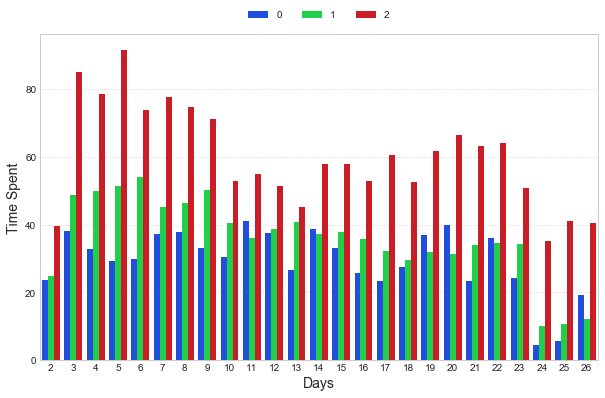

In [316]:
ax = sns.barplot(x=full_df.day_count, y=full_df.av_TS_perD, hue=full_df.admin_experiment_group, data=full_df, errwidth=0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fancybox=True, shadow=True)
ax.set_xlabel('Days', fontsize = 14)
ax.set_ylabel('Time Spent',fontsize = 14)

## Weekly Av. Statistics per user per group


index,worker_id,group,total_weeks,1,2,3,4,norm_w3,norm_w2
0,a10bh9pycyukdj,2,4,131.071,83.751,49.239,84.58,-0.624,-0.361
1,a10ojzhjkjomx8,0,3,9.953,12.011,25.691,NaN,1.581,0.207
2,a110kenbxu7suj,1,3,6.046,2.726,6.893,NaN,0.140,-0.549
3,a11366ca9g9vzy,0,3,12.417,8.619,6.210,NaN,-0.500,-0.306
4,a12mv66u9vglq1,2,3,10.951,7.904,0.000,NaN,-1.000,-0.278


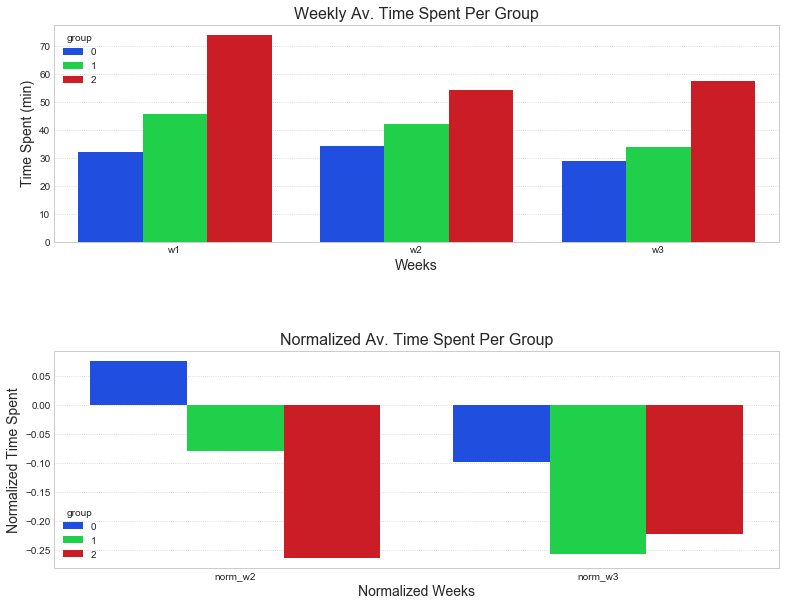

In [461]:
# For each worker_id calculated the average daily usage of FB for weeks 1-3 
# Plotted a bar plot of three weeks and three conditions

import numpy as np

w = 3 # How many weeks to plot (choose as study progresses)

weeks = pd.DataFrame() # Empty data Frame
for g in groups: 
    temp_df = full_df.loc[full_df.admin_experiment_group==g,] # extract each group separatly 
    workers = temp_df.worker_id.drop_duplicates()  # make list of uniwue worker id's for that group
    for i in workers: # for each worker take his time_spent divide into groups of 7 to make a week and count the av. 
        weekly = temp_df.time_spent[(temp_df.worker_id==i)]
        t = pd.DataFrame(weekly.groupby(np.arange(len(weekly))//7).mean().round(3))
        t['index'] = range(1,len(t)+1)
        t['worker_id'] = i
        t['group'] = g
        t['total_weeks'] = len(t)
        weeks = weeks.append(t)
data_weeks = weeks.pivot_table(index=['worker_id','group', 'total_weeks'], columns='index', values='time_spent')
data_weeks = data_weeks.reset_index()

for i in range(w,0,-1):
    s = 'norm_w'+str(i)
    if i == 1:
        break
    data_weeks[s] = ((data_weeks[i]-data_weeks[1])/data_weeks[1]).round(3)
display(data_weeks.head())

# -------------------------------------------------------------------------------------------------------------------
final_d = pd.DataFrame()
for g in groups:
    t_df = data_weeks.loc[data_weeks.group==g,]
    temp_d = list(t_df.iloc[:,3:(3+w)].apply(lambda x: round(x.sum()/x.count(),2)))
    temp_d = pd.DataFrame([temp_d], columns=['w'+str(w) for w in range(1,w+1)])
    temp_d['group'] = g
    final_d = final_d.append(temp_d)

# For Weekly plot    
final_d_ = final_d.iloc[:,0:(w+1)]
final_d_  = pd.melt(final_d_, id_vars=['group'], value_vars=list(final_d_)[0:w])

for i in range(w,0,-1):
    if i == 1:
        break
    s = 'norm_w'+str(i)
    search = 'w'+str(i)
    final_d[s] = ((final_d[search]-final_d.iloc[:,0])/final_d.iloc[:,0]).round(3)

# For Normalized plot
final_d_n  = pd.melt(final_d, id_vars=['group'], value_vars=list(final_d)[w+1:]).sort_index(by=['variable'])

# PLOTTING
f, (ax1, ax2) = plt.subplots(2)
sns.barplot(final_d_.variable , final_d_.value ,hue = final_d_.group, errwidth=0, ax=ax1)
sns.barplot(final_d_n.variable,final_d_n.value, hue = final_d_n.group,errwidth=0, ax=ax2)
f.subplots_adjust(hspace=.5)
f.set_size_inches(13, 10)
ax1.set_title('Weekly Av. Time Spent Per Group', fontsize = 16)
ax1.set_xlabel('Weeks', fontsize = 14)
ax1.set_ylabel('Time Spent (min)',fontsize = 14)
ax2.set_title('Normalized Av. Time Spent Per Group', fontsize = 16)
ax2.set_xlabel('Normalized Weeks', fontsize = 14)
ax2.set_ylabel('Normalized Time Spent',fontsize = 14)
    

  